# Cleaning data: removing blur

The $NO_2$ data is in principle very useful for estimating traffic. However, $NO_2$ is subject to weather. Wind will carry $NO_2$ over large distances, and rain will wash it out of the atmosphere. To be able to estimate traffic using $NO_2$ data, we will need to account for these distortions. 

In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.ndimage as scn
import scipy.signal as scs
import scipy.fftpack as scf
import scipy.stats as st
import skimage.restoration as sir
import netCDF4 as nc

Looking at the data, it is hard to make out any single pointsources of $NO_2$. Weather has blurred our measurements. 

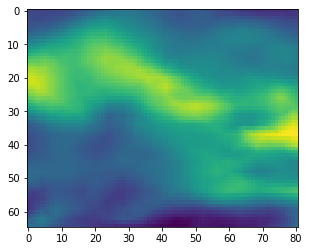

In [3]:
dataMarch1918 = nc.Dataset("./data/no2_germany_march2019_1800.nc", "r")['tcno2']

data = dataMarch1918[1]
plt.imshow(data)

Note, however, that this blur is not exactly a Gaussian blur. Even though we are looking at the data from a large distance, it seems that generally wind is moving $NO_2$ in a more or less consistent direction at every pixel. The kind of blur we are dealing with here seems somewhat similar to motion blur. 

This is forunate, because motion blur is easily modelled with a simple convolution.

Text(0.5, 1.0, 'motion blurred picture')

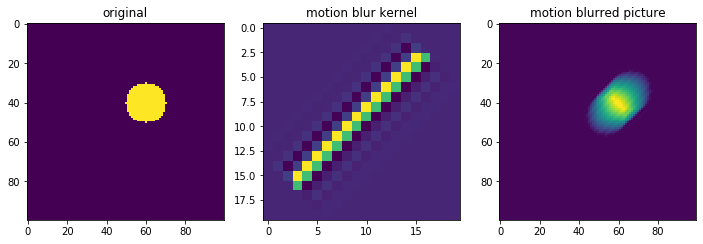

In [4]:
def distance(v1, v2):
    x1, y1 = v1
    x2, y2 = v2
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def pointMtrx(R, C, cx, cy, rad):
    mtrx = np.zeros((R, C))
    for r in range(R):
        for c in range(C):
            if distance((r, c), (cx, cy)) <= rad:
                mtrx[r, c] = 1
    return mtrx


def motionBlurKernel(degrees, n):

    # rotated line
    c = int((n-1)/2)
    kernel = np.zeros((n, n))
    kernel[c, :] = np.ones(n)
    kernel = scn.rotate(kernel, degrees)

    # crop
    N, _ = kernel.shape
    delta = int((N - n) / 2)
    if delta > 0:
        kernel = kernel[delta:-delta, delta:-delta]
    
    # normalize
    kernel = kernel / np.sum(kernel)
    return kernel


pt = pointMtrx(100, 100, 40, 60, 10)
mbk = motionBlurKernel(45, 20)
blurred = scs.convolve2d(pt, mbk, 'same')

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(pt)
axes[0].set_title('original')
axes[1].imshow(mbk)
axes[1].set_title('motion blur kernel')
axes[2].imshow(blurred)
axes[2].set_title('motion blurred picture')

As you can see, it was not hard to create a simple motion-blur effect with one single convolution operation. 
Convolutions are nice to work with, because in principle they can be undone again, using a process often called *deconvolution*.

Text(0.5, 1.0, 'reconstructed')

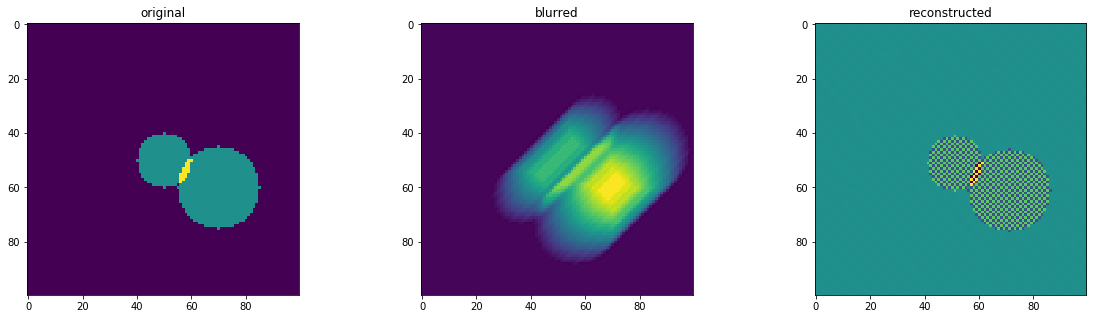

In [5]:
def centerPad(kernel, n):
    l, _ = kernel.shape
    m = np.zeros((n, n))
    delta = int((n - l) / 2)
    m[delta:delta+l, delta:delta+l] = kernel
    return m

def filterMotionBlur(image, angle, width):
    L, _ = image.shape
    kernel = motionBlurKernel(angle, width)
    kernel_p = centerPad(kernel, L)
    F_image = scf.fftshift( np.fft.fft2(image) )
    F_kernel = scf.fftshift( np.fft.fft2(kernel_p) )
    F_reconstr = F_image / F_kernel
    reconstr = scf.ifftshift( np.fft.ifft2(F_reconstr) )
    return reconstr



# image
point = pointMtrx(100, 100, 50, 50, 10)
point += pointMtrx(100, 100, 60, 70, 15)
noiseK = motionBlurKernel(45, 40)
image = scs.convolve2d(point, noiseK, 'same')

# reconstruction
pointReconstr = filterMotionBlur(image, 45, 40)

# #plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(point)
axes[0].set_title('original')
axes[1].imshow(image)
axes[1].set_title('blurred')
axes[2].imshow(np.real(pointReconstr))
axes[2].set_title('reconstructed')

The image above shows that we can - in principle - easily undo a motion-blur effect. This requires that we know the kernel, in this case the motion-blur-filter. If, however, we make even a small mistake in our kernel (in this case, say, using a blur-angle of `50` instead of `45` degrees), the reconstruction looks terrible:

Text(0.5, 1.0, 'slightly off reconstruction')

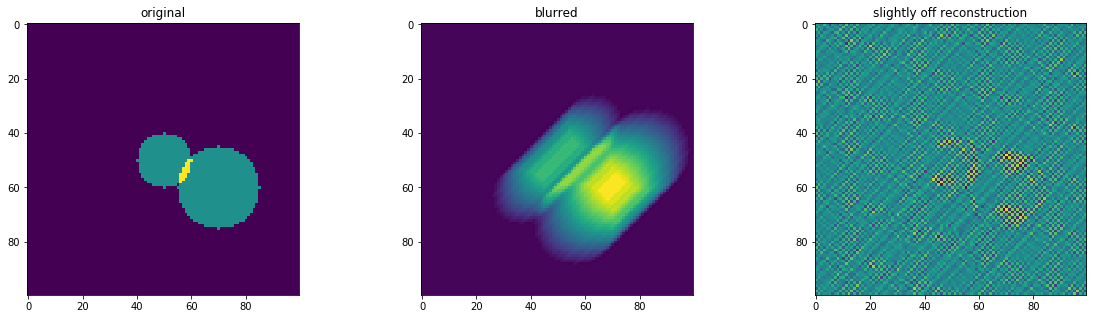

In [6]:

# reconstruction
pointReconstr = filterMotionBlur(image, 50, 40)

# #plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(point)
axes[0].set_title('original')
axes[1].imshow(image)
axes[1].set_title('blurred')
axes[2].imshow(np.real(pointReconstr))
axes[2].set_title('slightly off reconstruction')

We can do a little bit better using the Wiener filter. But Wiener really only helps when noise is present, not so much when we make errors in our kernel. 

Text(0.5, 1.0, 'slightly off reconstruction')

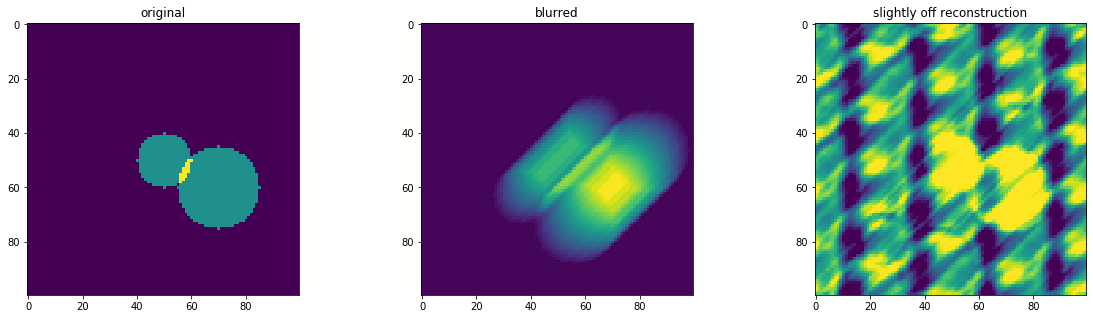

In [7]:
def filterMotionBlurWiener(image, angle, spread):
    kernel = motionBlurKernel(angle, spread)
    reconst, info = sir.unsupervised_wiener(image, kernel)
    return kernel, reconst, info


# reconstruction
kernel, pointReconstr, info = filterMotionBlurWiener(image, 50, 40)

# #plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(point)
axes[0].set_title('original')
axes[1].imshow(image)
axes[1].set_title('blurred')
axes[2].imshow(np.real(pointReconstr))
axes[2].set_title('slightly off reconstruction')

Let's see how well our function does with real data.

Text(0.5, 1.0, 'deconvoluted data')

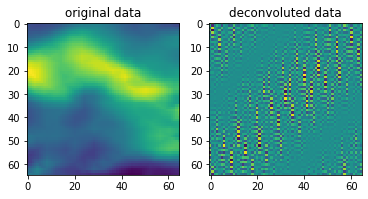

In [8]:
R, C = data.shape
data_sq = data[:, :R]
# we're just estimating that the wind direction is around 160 degrees, streching pointsources by 10 pixels.
data_clean = filterMotionBlur(data_sq, 160, 10)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(data_sq)
ax[0].set_title('original data')
ax[1].imshow(np.real(data_clean))
ax[1].set_title('deconvoluted data')

Ouch! Clearly our naive approach does not work very well when we are dealing with more complicated data. Indeed, deconvolution is notoriously sensitive to even smaller numeric aberations.

Maybe things work better when we work with mean data?

In [9]:
dataMarch1918 = nc.Dataset("./data/no2_germany_march2019_1800.nc", "r")
dataMarch1900 = nc.Dataset("./data/no2_germany_march2019_0000.nc", "r")
dataApril1918 = nc.Dataset("./data/no2_germany_april2019_1800.nc", "r")
dataApril1900 = nc.Dataset("./data/no2_germany_april2019_0000.nc", "r")
dataFebr1800 = nc.Dataset("./data/no2_germany_february2020_1800.nc", "r")
dataFebr0000 = nc.Dataset("./data/no2_germany_february2020_0000.nc", "r")
dataMarch1800 = nc.Dataset("./data/no2_germany_march2020_1800.nc", "r")
dataMarch0000 = nc.Dataset("./data/no2_germany_march2020_0000.nc", "r")
dataApril1800 = nc.Dataset("./data/no2_germany_april2020_1800.nc", "r")
dataApril0000 = nc.Dataset("./data/no2_germany_april2020_0000.nc", "r")

Tfeb, X, Y = dataFebr1800['tcno2'].shape
Tmarch, _, _ = dataMarch1800['tcno2'].shape
Tapril, _, _ = dataApril1800['tcno2'].shape
Tmeassure = 21
Tdelta = 30

beforeVals1800 = np.concatenate((dataMarch1918['tcno2'][Tmeassure:], dataApril1918['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
beforeVals0000 = np.concatenate((dataMarch1900['tcno2'][Tmeassure:], dataApril1900['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals1800 = np.concatenate((dataMarch1800['tcno2'][Tmeassure:], dataApril1800['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals0000 = np.concatenate((dataMarch0000['tcno2'][Tmeassure:], dataApril0000['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))

beforeVals1800mean = np.mean(beforeVals1800, axis=0)
beforeVals0000mean = np.mean(beforeVals0000, axis=0)
afterVals1800mean = np.mean(afterVals1800, axis=0)
afterVals0000mean = np.mean(afterVals0000, axis=0)



fracNontrafficNight = 0.6
nontraffic = fracNontrafficNight * afterVals0000mean
trafficBefore = beforeVals1800mean - nontraffic
trafficAfter = afterVals1800mean - nontraffic

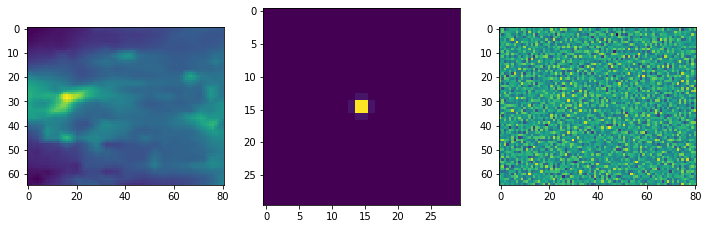

In [10]:
def gkern(kernlen=21, nsig=3):
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()


kernel = gkern(30, 29)
reconst, info = sir.unsupervised_wiener(trafficAfter, kernel)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(trafficAfter)
axes[1].imshow(kernel)
axes[2].imshow(reconst)

Hmmm, a Gaussian kernel clearly does not do the trick, either. 
Let's try to estimate the PSF from a known pointsource; in this case: Berlin!

In [11]:
def calcPsfFromPointsource(data, rowPS, colPS, windowSize):
    delta = int(0.5 + windowSize / 2)
    windowObs = data[rowPS - delta : rowPS + delta, colPS - delta : colPS + delta]
    bgVal = np.min(windowObs)
    sumPS = np.sum(windowObs - bgVal)
    windowReal = windowObs - bgVal
    windowReal[delta, delta] += sumPS
    psf, noise = sir.unsupervised_wiener(windowObs, windowReal)
    return psf

def cleanDataWiener(dataObs, psf):
    dataReal, noise = sir.unsupervised_wiener(dataObs, psf)
    return dataReal

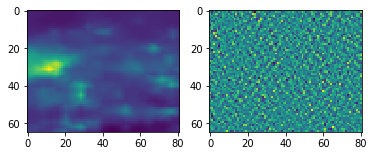

In [12]:
rowBerlin = 20
colBerlin = 67
psf = calcPsfFromPointsource(afterVals0000mean, rowBerlin, colBerlin, 10)
afterVals0000meanCorrected = cleanDataWiener(afterVals0000mean, psf)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(afterVals0000mean)
axes[1].imshow(afterVals0000meanCorrected)

Maybe things work better when we focus on a samller area, where wind is more uniform. Let's pick Bavaria for starters.

In [13]:
def round(v):
    return int(v + 0.5)


def coordsToIndex(lon, lat):
    R, C = beforeVals0000mean.shape
    lat0 = 47
    lat1 = 55
    lon0 = 5
    lon1 = 15
    deltaLat = (lat1 - lat0) / R
    deltaLon = (lon1 - lon0) / C
    # lat = lat0 + (R-r) * deltaLat
    r = R - ((lat - lat0) / deltaLat)
    # lon = lon0 + c * deltaLon
    c = (lon - lon0) / deltaLon
    return round(r), round(c)


def indexToCoords(r, c):
    R, C = beforeVals0000mean.shape
    lat0 = 47
    lat1 = 55
    lon0 = 5
    lon1 = 15
    deltaLat = (lat1 - lat0) / R
    deltaLon = (lon1 - lon0) / C
    lat = lat0 + (R-r) * deltaLat
    lon = lon0 + c * deltaLon
    return lon, lat



def matrixInsideShape(data, shape):
    masked = np.zeros(data.shape)
    for r, row in enumerate(data):
        for c, col in enumerate(row):
            lon, lat = indexToCoords(r, c)
            if shape.contains(shp.geometry.Point(lon, lat)):
                masked[r, c] = col
    return masked


In [15]:
bboxBayern = [(9, 47), (14, 51)]
bboxBayernIndx = [coordsToIndex(*e) for e in bboxBayern]
bboxBayernIndx

[(65, 32), (33, 73)]

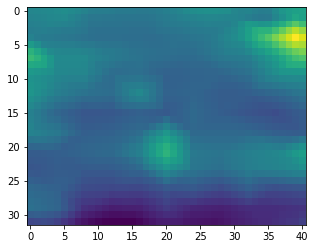

In [26]:
(r1, c0), (r0, c1) = bboxBayernIndx
no2Bayern = afterVals1800mean[r0:r1, c0:c1]
plt.imshow(no2Bayern)
#plt.imshow(pointMtrx(*(no2Bayern.shape), 21, 20, 1), alpha=0.1)

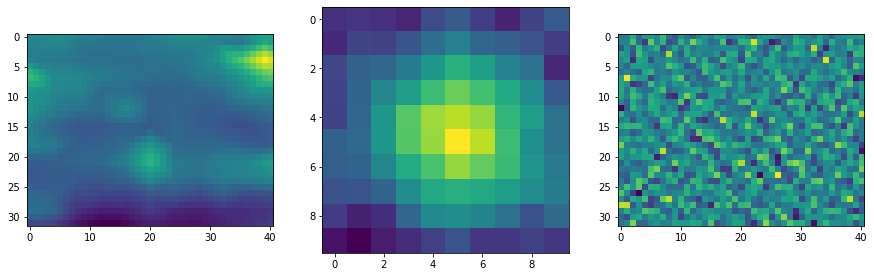

In [29]:
psf = calcPsfFromPointsource(no2Bayern, 21, 20, 10)
no2BayernCorrected = cleanDataWiener(no2Bayern, psf)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(no2Bayern)
axes[1].imshow(psf)
axes[2].imshow(no2BayernCorrected)

Hm. This didn't  go well. Maybe we can get better results  playing around manually?

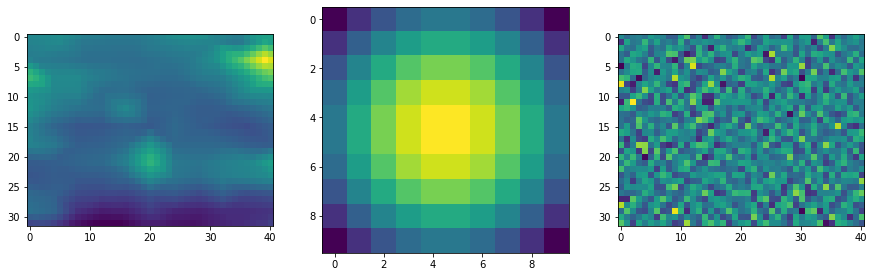

In [35]:
kernel = gkern(10, 1)
no2BayernCorrected2, info = sir.unsupervised_wiener(no2Bayern, kernel)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(no2Bayern)
axes[1].imshow(kernel)
axes[2].imshow(no2BayernCorrected2)

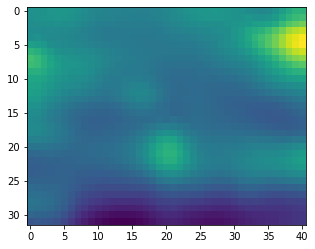

In [44]:
no2BayernCorrected3 = sir.denoise_tv_bregman(no2Bayern, 1)
plt.imshow(no2BayernCorrected3)

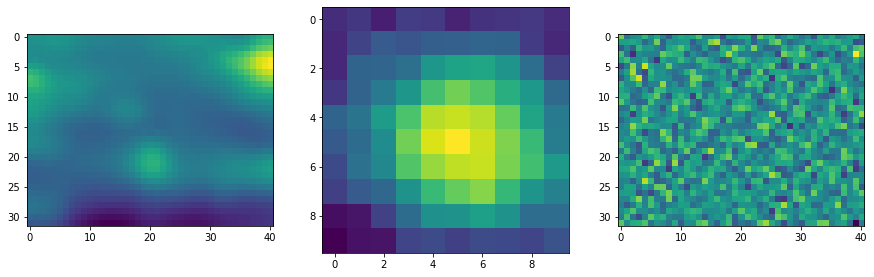

In [46]:
psf = calcPsfFromPointsource(no2BayernCorrected3, 21, 20, 10)
no2BayernCorrected4 = cleanDataWiener(no2BayernCorrected3, psf)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(no2BayernCorrected3)
axes[1].imshow(psf)
axes[2].imshow(no2BayernCorrected4)

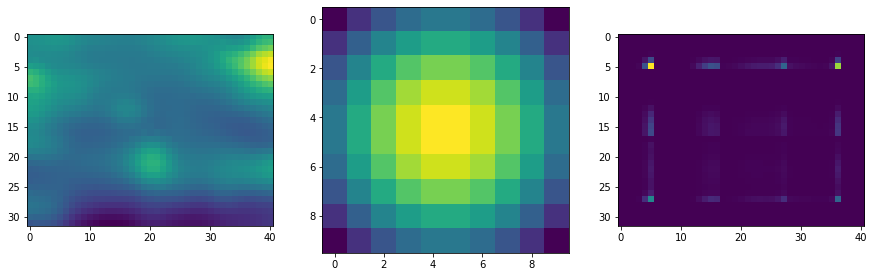

In [51]:
psf = gkern(10, 1) # calcPsfFromPointsource(no2BayernCorrected3, 21, 20, 10)
no2BayernCorrected4 = sir.richardson_lucy(no2BayernCorrected3, psf, 100, True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(no2BayernCorrected3)
axes[1].imshow(psf)
axes[2].imshow(no2BayernCorrected4)